In [9]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np

import theano

In [10]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)

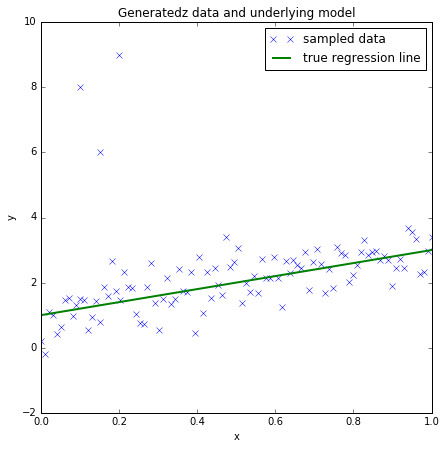

In [11]:
### Plot the data + reg line + outliers
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generatedz data and underlying model')
ax.plot(x_out, y_out, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0)

In [7]:
### Estimating model with normal  likelihood by default
with pm.Model() as model:
    pm.glm.glm('y ~ x', data)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step, progressbar=False)

In [10]:
### Plotting the found reg lines
plt.subplot(111, xlabel='x', ylabel='y', 
            title='Posterior predictive regression lines')
plt.plot(x_out, y_out, 'x', label='data')
pm.glm.plot_posterior_predictive(trace, samples=100, 
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')

plt.legend(loc=0)

In [1]:
# high uncertainty was visible above, since
# the normal likelihood has small tails so was strongly affected
# by the outliers. Try the Student T distribution which has thick tails.
normal_dist = pm.Normal.dist(mu=0, sd=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal', lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend()

In [19]:
### Estimating model with Student T distribution
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.glm('y ~ x', data, family=family)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_robust = pm.sample(2000, step, progressbar=False)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
pm.glm.plot_posterior_predictive(trace_robust,
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')
plt.legend()

In [ ]:
### Conclusion: 
# now the outliers are barely influencing the estimation reg lines at all
# because the likelihood function is Student T instead of Normal and so
# assumes that outliers are more probable.